[View in Colaboratory](https://colab.research.google.com/github/snastase/isc-tutorial/blob/master/isc_tutorial.ipynb)

<h1>Intersubject correlation (ISC) tutorial</h1>
This tutorial jupyter notebook accompanies the manuscript "Measuring shared responses across subjects using intersubject correlation" by Keysers, Gazzola, Nastase, and Hasson. The goal of the tutorial is to introduce basic intersubject correlation (ISC) analyses (Hasson et al., 2004, 2010) and subsequent statistical tests as implemented in Python using the Brain Imaging Analysis Kit ([BrainIAK](http://brainiak.org/)).

---

Author: Sam Nastase

## Getting started
First, we'll need to [install BrainIAK](http://brainiak.org/docs/installation.html) and its requirements—this may take a few minutes.

**THIS WILL NOT WORK UNTIL NEW ISC CODE IS PUSHED INTO PUBLIC BRAINIAK!!!—skip to the next one for now**

In [0]:
#!apt install build-essential libgomp1 libmpich-dev mpich python3-dev \
#             python3-pip python3-venv
#!pip install brainiak

If unable to install BrainIAK, we can use basic ISC functionality without the full BrainIAK package. We'll download `isc_standalone.py` from the [GitHub repository](https://github.com/snastase/isc-tutorial) for this tutorial and load the necessary modules locally.

In [0]:
from urllib.request import urlretrieve
urlretrieve('https://github.com/snastase/isc-tutorial/'
            'raw/master/isc_standalone.py', 'isc_standalone.py');
from isc_standalone import (isc, isfc, bootstrap_isc, permutation_isc,
                            timeshift_isc, phaseshift_isc)

Finally, we'll load several other useful Python modules.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, pearsonr, zscore
from scipy.spatial.distance import squareform
from statsmodels.stats.multitest import multipletests

## Example data
We'll create a simple simulated dataset for quickly applying ISC analyses, then apply the analyses to a real fMRI dataset where participants listened to a spoken narrative ([Pie Man](https://themoth.org/stories/pie-man) by Jim O'Grady). Our simulated data will have 1,000 voxels in total comprising 10 "networks" and 300 time points (or TRs).

**WORKING ON A SOLUTION FOR SERVING A SUBSET OF THE PIEMAN DATA PUBLICLY—currently it requires a 14 GB tarball download :(**

In [0]:
# Set parameters for toy time series data
n_subjects = 20
n_TRs = 300
n_voxels = 1000

# Create simple simulated data with high intersubject correlation
def simulated_timeseries(n_subjects, n_TRs, n_voxels=1, noise=1):
  signal = np.random.randn(n_TRs, n_voxels // 100)
  data = [zscore(np.repeat(signal, 100, axis=1) +
                 np.random.randn(n_TRs, n_voxels) * noise,
                 axis=0)
          for subject in np.arange(n_subjects)]
  return data

# List of subject datasets
data = simulated_timeseries(n_subjects, n_TRs, n_voxels=n_voxels)

Simulated data shape first subject: (300, 1000) 
i.e., 300 time points and 1000 voxels


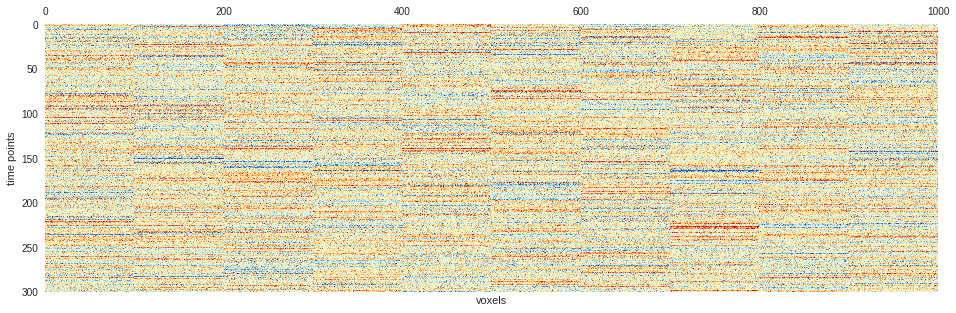

In [12]:
# Inspect the shape of one of our simulated datasets
print(f"Simulated data shape first subject: {data[0].shape} "
      f"\ni.e., {data[0].shape[0]} time points and {data[0].shape[1]} voxels")

# Create a simple visualization of the data
plt.matshow(data[0], cmap='RdYlBu', vmin=-3, vmax=3)
plt.grid(False)
plt.xlabel('voxels')
plt.ylabel('time points');

## ISC analysis
Let's start very simple by computing the ISC for a single voxel (or ROI) across only two participants. This should give us a simple Pearson correlation value (and should match other implementations of Pearson correlation). Note that when you call the `isc` function with `verbose=True` (the default), it outputs some warnings describing what it infers about the input data. If these don't match your assumptions, your input data may be organized improperly.

In [13]:
# Get the time series for a single voxel in two subjects
subject_a = data[0][:, 0]
subject_b = data[1][:, 0]

# Check the shape of these mini-datasets
print(f"Subject A, first voxel, shape = {subject_a.shape} "
      f"\nSubject B, first voxel, shape = {subject_b.shape}")

# Combine these into a list
both_subjects = [subject_a, subject_b]

# Compute the ISC for this voxel across the two subjects
iscs = isc(both_subjects, pairwise=True, verbose=True)
print(f"ISC for first voxel across subjects A and B = {iscs[0][0]}")

# NB: even for a single voxel, the output ISC is shaped to 
# to accommodate an n_ISCs x n_voxels matrix
print(f"ISC output shape = {iscs.shape}"
      f"\ni.e., {iscs.shape[0]} ISC value(s) by {iscs.shape[0]} voxel(s)")

# Check that ISC output matches of other correlation functions in python
numpy_corrcoef = np.corrcoef(subject_a, subject_b)[0, 1]

scipy_pearsonr = pearsonr(subject_a, subject_b)[0]

print(f"BrainIAK ISC = {iscs[0][0]}"
      f"\nNumpy's correlation = {numpy_corrcoef}"
      f"\nScipy's correlation = {scipy_pearsonr}")
assert np.isclose(iscs, numpy_corrcoef) and np.isclose(iscs, scipy_pearsonr)

Subject A, first voxel, shape = (300,) 
Subject B, first voxel, shape = (300,)
Assuming 2 subjects with 300 time points and 1 voxel(s) or ROI(s).
Only two subjects! Simply computing Pearson correlation.
ISC for first voxel across subjects A and B = 0.5074733454204495
ISC output shape = (1, 1)
i.e., 1 ISC value(s) by 1 voxel(s)
BrainIAK ISC = 0.5074733454204495
Numpy's correlation = 0.5074733454204493
Scipy's correlation = 0.5074733454204495


When there are three or more subjects, we can compute ISCs using either the pairwise approach (`pairwise=True`), where we compute ISCs between each pair of subjects, or the leave-one-out (`pairwise=False`) approach, where we compute ISCs between each subject and the average time series of other subjects.

### Pairwise approach
Now we'll run the full-scale ISC analysis across all voxels and subjects using the pairwise approach. For a given voxel, the correlations between each pair of subjects are represented in a vector of length
```
n_subjects * (n_subjects - 1) / 2
```
or 190 pairs for 20 subjects. This vector of pairs corresponds to the off-diagonal values of a symmetric subjects-by-subjects correlation matrix.



In [14]:
# Pairwise approach across all subjects and voxels
iscs = isc(data, pairwise=True)

# Check shape of output ISC values
print(f"ISC values shape = {iscs.shape} \ni.e., {iscs.shape[0]} "
      f"pairs and {iscs.shape[1]} voxels"
      f"\nMinimum ISC = {np.amin(iscs)}; maximum ISC = {np.amax(iscs)}")

Assuming 20 subjects with 300 time points and 1000 voxel(s) or ROI(s).
ISC values shape = (190, 1000) 
i.e., 190 pairs and 1000 voxels
Minimum ISC = 0.27337349176106507; maximum ISC = 0.6688005228244231


For a given voxel, we can convert the vector of pairs to the full correlation matrix for visualization. In the simulated dataset, all subjects were designed to have high ISCs; however, we can add noise to some of the subjects and then visualize the ISC matrix.

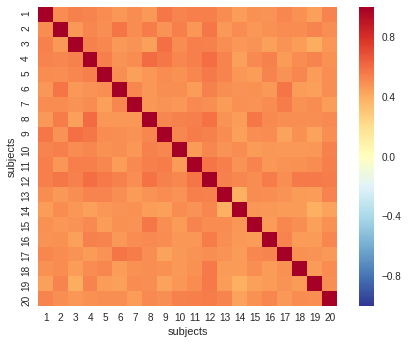

Assuming 20 subjects with 300 time points and 1000 voxel(s) or ROI(s).


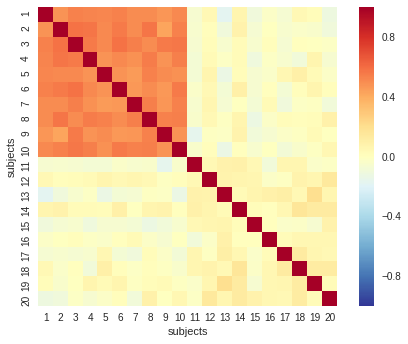

In [15]:
# Visualize the correlation matrix for one voxel
isc_matrix = squareform(iscs[:, 0])
np.fill_diagonal(isc_matrix, 1)
sns.heatmap(isc_matrix, cmap="RdYlBu_r", vmin=-1, vmax=1, square=True, 
            xticklabels=range(1, 21), yticklabels=range(1, 21))
plt.xlabel('subjects')
plt.ylabel('subjects')
plt.show()

# Create noisier data
noisy_data = np.dstack((np.dstack((
    simulated_timeseries(n_subjects // 2, n_TRs,
                         n_voxels=n_voxels, noise=1))),
                        np.dstack((
    simulated_timeseries(n_subjects // 2, n_TRs,
                         n_voxels=n_voxels, noise=5)))))

# Recompute ISC and visualize data with noisy subjects
noisy_iscs = isc(noisy_data, pairwise=True)
isc_matrix = squareform(noisy_iscs[:, 0])
np.fill_diagonal(isc_matrix, 1)
sns.heatmap(isc_matrix, cmap="RdYlBu_r", vmin=-1, vmax=1, square=True, 
            xticklabels=range(1, 21), yticklabels=range(1, 21))
plt.xlabel('subjects')
plt.ylabel('subjects')
plt.show()

### Leave-one-out approach
Instead of computing ISCs between each pair of subjects, for each subject we can compute the ISC between that subject and the average of all other subjects. Notice that the observed ISC values are typically higher in the leave-one-out approach due to computing correlations between the left-out subject and the cleaner averaged time series from the remaining subjects.

In [16]:
# Leave-one-out approach
iscs = isc(data, pairwise=False)

# Check shape of output ISC values
print(f"ISC values shape = {iscs.shape} \ni.e., {iscs.shape[0]} "
      f"left-out subjects and {iscs.shape[1]} voxel(s)"
      f"\nMinimum ISC = {np.amin(iscs)}; maximum ISC = {np.amax(iscs)}")

Assuming 20 subjects with 300 time points and 1000 voxel(s) or ROI(s).
ISC values shape = (20, 1000) 
i.e., 20 left-out subjects and 1000 voxel(s)
Minimum ISC = 0.5634577468384401; maximum ISC = 0.793971459641619


### Input types
Currently, we're a submitting a list of numpy arrays to BrainIAK's `isc` function where each item in the list is a subject's response time course over some number of voxels. Alternatively, we could stack subjects along the 3rd dimension (`np.dstack`) into a single 3-dimensional numpy array and submit this to the `isc` function. If the `isc` function receives a single numpy array, it will assume that the last dimension indexes subjects.

In [17]:
# Input a list of subjects (same as before)
iscs = isc(data, pairwise=False)

# Stack subjects in 3rd-dimension and recompute ISC
data_stack = np.dstack(data)
print(f"Stacked data shape = {data_stack.shape}"
      f"\ni.e., {data_stack.shape[0]} time points, {data_stack.shape[1]} "
      f"voxels, and {data_stack.shape[2]} subjects")

# Input stacked numpy array
iscs_from_stack = isc(data, pairwise=False)

# Make sure the ISC outputs are the same
assert np.array_equal(iscs, iscs_from_stack)

Assuming 20 subjects with 300 time points and 1000 voxel(s) or ROI(s).
Stacked data shape = (300, 1000, 20)
i.e., 300 time points, 1000 voxels, and 20 subjects
Assuming 20 subjects with 300 time points and 1000 voxel(s) or ROI(s).


### Summary statistics
Rather than returning ISC values for each pair of subject (in the pairwise approach) or each left-out subject (in the leave-one-out approach), we can use the `summary_statistic` argument to output either the mean or median across the values. Note that by default `summary_statistic=False`. If we request the mean ISC value, the `isc` function will internally apply the Fisher *z*-transformation (`np.arctanh`) prior to computing the mean, then apply the inverse Fisher *z*-transformation (`np.tanh`) to the mean value.

In [18]:
# Compute mean leave-one-out ISC
iscs = isc(data, pairwise=False, summary_statistic=np.mean)

print(f"ISC values shape = {iscs.shape} \ni.e., {iscs.shape[0]} "
      f"mean value across left-out subjects and {iscs.shape[1]} voxel(s)"
      f"\nMean ISC for first voxel = {iscs[0, 0]}")

# Compute median leave-one-out ISC
iscs = isc(data, pairwise=False, summary_statistic=np.median)

print(f"ISC values shape = {iscs.shape} \ni.e., {iscs.shape[0]} "
      f"median value across left-out subjects and {iscs.shape[1]} voxel(s)"
      f"\nMedian ISC for first voxel = {iscs[0, 0]}")

Assuming 20 subjects with 300 time points and 1000 voxel(s) or ROI(s).
ISC values shape = (1, 1000) 
i.e., 1 mean value across left-out subjects and 1000 voxel(s)
Mean ISC for first voxel = 0.6880850040187962
Assuming 20 subjects with 300 time points and 1000 voxel(s) or ROI(s).
ISC values shape = (1, 1000) 
i.e., 1 median value across left-out subjects and 1000 voxel(s)
Median ISC for first voxel = 0.6830855858629807


## Statistical tests
BrainIAK provides several nonparametric statistical tests for ISC analysis. Nonparametric tests are preferred due to the inherent correlation structure across ISC values—each subject contributes to the ISC of other subjects, violating assumptions of independence required for standard parametric tests (e.g., t-test, ANOVA). The nonparametric statistical tests discussed below return the actual observed ISC values, p-values, and optionally the resampling distribution (the bootstrap hypothesis test also returns confidence intervals around the observed ISC statistic). For expediency, we only use 200 resampling iterations here, but 1,000 or more iterations are generally recommended.

### Phase randomization
One approach for statistically assessing ISCs is to randomize the phase of time series across subjects prior to computing ISCs (e.g., Lerner et al., 2011; Simony et al., 2016). This method requires recomputing ISC at each iteration of the randomization test, and is therefore slow. In the pairwise approach, we phase-randomize each subject prior to computing ISCs; however, in the leave-one-out approach, we only phase-randomize the left-out subject prior to computing ISC. At each iteration of the phase randomization test, the same random phase shift is used across all voxels to preserve the spatial autocorrelation of typical fMRI data.

In [19]:
# Phase randomization using pairwise approach (takes a couple minutes)
observed, p, distribution = phaseshift_isc(data, pairwise=True,
                                           summary_statistic=np.median,
                                           n_shifts=200,
                                           return_distribution=True)

Assuming 20 subjects with 300 time points and 1000 voxel(s) or ROI(s).


In [20]:
# Inspect shape of null distribution
print(f"Null distribution shape = {distribution.shape}"
      f"\ni.e., {distribution.shape[0]} randomizations "
      f"and {distribution.shape[1]} voxels")

# Get actual ISC value and p-value for first voxel
print(f"Actual observed ISC value for first voxel = {observed[0][0]}, "
      f"p-value from randomization test = {p[0][0]}")

Null distribution shape = (200, 1000)
i.e., 200 randomizations and 1000 voxels
Actual observed ISC value for first voxel = 0.4963517603185915, p-value from randomization test = 0.004975124378109453


### Circular time-shift randomization
A conceptually similar nonparametric approach is to circularly shift the response time series across subjects by random offsets (Kauppi et al., 2014). Time points that would be shifted beyond the end of the time series are wrapped around to the beginning of the time series.

In [21]:
# Circular time-shift using pairwise approach (takes a couple minutes)
observed, p, distribution = timeshift_isc(data, pairwise=True,
                                          summary_statistic=np.median,
                                          n_shifts=200,
                                          return_distribution=True)

Assuming 20 subjects with 300 time points and 1000 voxel(s) or ROI(s).


In [22]:
# Inspect shape of null distribution
print(f"Null distribution shape = {distribution.shape}"
      f"\ni.e., {distribution.shape[0]} randomizations "
      f"and {distribution.shape[1]} voxels")

# Get actual ISC value and p-value for first voxel
print(f"Actual observed ISC value for first voxel = {observed[0][0]}, "
      f"p-value from randomization test = {p[0][0]}")

Null distribution shape = (200, 1000)
i.e., 200 randomizations and 1000 voxels
Actual observed ISC value for first voxel = 0.4963517603185915, p-value from randomization test = 0.004975124378109453


### Bootstrap hypothesis test
We can also perform group-level statistical tests that operate directly on the observed ISC values and do not require recomputing ISCs. For one-sample tests, we can resample subjects with replacement to construct a bootstrap distribution around our observed ISC statistic (Chen et al., 2016). We can compute confidence intervals around the test statistic using the `ci_percentile` option (default 95%). Hypothesis test is performed by shifting the bootstrap distribution to zero. Note that when constructing the bootstrap distribution using the pairwise approach, subjects (i.e., rows and columns in the subject-by-subject correlation matrix) are sampled with replacement, not pairs (which would disrupt the correlation structure among pairs).

In [23]:
# Compute ISCs and then run bootstrap hypothesis test on ISCs
iscs = isc(data, pairwise=True, summary_statistic=None)
observed, ci, p, distribution = bootstrap_isc(iscs, pairwise=True,
                                              ci_percentile=95,
                                              summary_statistic=np.median,
                                              n_bootstraps=200,
                                              return_distribution=True)

Assuming 20 subjects with 300 time points and 1000 voxel(s) or ROI(s).
Assuming 20 subjects with and 1000 voxel(s) or ROI(s).


In [24]:
# Inspect shape of null distribution
print(f"Null distribution shape = {distribution.shape}"
      f"\ni.e., {distribution.shape[0]} bootstraps "
      f"and {distribution.shape[1]} voxels")

# Get actual ISC value and p-value for first voxel
print(f"Actual observed ISC value for first voxel = {observed[0][0]}, "
      f"p-value from bootstrap hypothesis test = {p[0][0]}")

Null distribution shape = (200, 1000)
i.e., 200 bootstraps and 1000 voxels
Actual observed ISC value for first voxel = 0.4963517603185915, p-value from bootstrap hypothesis test = 0.004975124378109453


### Permutation test
We can use a permutation test to statistically evaluate one- or two-sample tests (Chen et al., 2016). In the case of a one-sample test, we use a sign-flipping (-1, +1) approach applied to the observed ISC. For a two-sample test, we supply a `group_assignment` list containing the group labels for each subject. The order of the group assignment list must match the order in which the subjects are supplied to the `isc` function. At each iteration, we randomly reassign the group labels, then compute the test statistic. In the one-sample test, there are `2**n_subjects` number of possible permutations, while in the the two-sample test, there are `n_subjects!` number of possible permutations. In both cases, if the requested number of permutations equals or exceeds the exhaustive list of permutations, an exact test is performed using all possible permutations. However, in most cases the number of subjects will yield an a prohibitively large number of permutations, in which case a Monte Carlo approximate permutation test is used instead of an exact test.

In [25]:
# Compute ISCs and then run one-sample permutation test on ISCs
iscs = isc(data, pairwise=True, summary_statistic=None)
observed, p, distribution = permutation_isc(iscs, pairwise=True,
                                            summary_statistic=np.median,
                                            n_permutations=200,
                                            return_distribution=True)

Assuming 20 subjects with 300 time points and 1000 voxel(s) or ROI(s).
No group assignment provided, performing one-sample test.
Assuming 20 subjects, 1 group(s), and 1000 voxel(s) or ROI(s).
One-sample approximate permutation test using sign-flipping procedure with Monte Carlo resampling.


In [26]:
# Inspect shape of null distribution
print(f"Null distribution shape = {distribution.shape}"
      f"\ni.e., {distribution.shape[0]} permutations "
      f"and {distribution.shape[1]} voxels")

# Get actual ISC value and p-value for first voxel
print(f"Actual observed ISC value for first voxel = {observed[0][0]}, "
      f"p-value from permutation test = {p[0][0]}")

Null distribution shape = (200, 1000)
i.e., 200 permutations and 1000 voxels
Actual observed ISC value for first voxel = 0.4963517603185915, p-value from permutation test = 0.004975124378109453


In [27]:
# Note that with few subjects, an exact test is performed
data_n6 = data[:6]
iscs = isc(data_n6, pairwise=True, summary_statistic=None)
observed, p, distribution = permutation_isc(iscs, pairwise=True,
                                            summary_statistic=np.median,
                                            n_permutations=200,
                                            return_distribution=True)

Assuming 6 subjects with 300 time points and 1000 voxel(s) or ROI(s).
No group assignment provided, performing one-sample test.
Assuming 6 subjects, 1 group(s), and 1000 voxel(s) or ROI(s).
One-sample exact permutation test using sign-flipping procedure with 2**6 (64) iterations.


If we have two groups we expect to have different ISC values, we must supply a `group_assignment` list. In the case of two groups, we compute the difference between the `summary_statistic` for each group. In the pairwise approach, we compute differences between the `summary_statistic` for within-group correlations, and ignore the between group correlations in the full subject-by-subject correlation matrix containing both groups. Furthermore, permutations are applied to subjects (i.e., rows and columns in the subject-by-subject correlation matrix) and not to pairs (which would disrupt the correlation structure among pairs). We'll construct a dataset where one group of subjects are noisier than the others.

In [28]:
# Create data with noisy subset of subjects
noisy_data = np.dstack((np.dstack((
    simulated_timeseries(n_subjects // 2, n_TRs,
                         n_voxels=n_voxels, noise=1))),
                        np.dstack((
    simulated_timeseries(n_subjects // 2, n_TRs,
                         n_voxels=n_voxels, noise=5)))))

# Create group_assignment variable with group labels
group_assignment = [1]*10 + [2]*10
print(f"Group assignments: \n{group_assignment}")

# Compute ISCs and then run two-sample permutation test on ISCs
iscs = isc(noisy_data, pairwise=True, summary_statistic=None)
observed, p, distribution = permutation_isc(iscs,
                                            group_assignment=group_assignment,
                                            pairwise=True,
                                            summary_statistic=np.median,
                                            n_permutations=200,
                                            return_distribution=True)

Group assignments: 
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Assuming 20 subjects with 300 time points and 1000 voxel(s) or ROI(s).
Assuming 20 subjects, 2 group(s), and 1000 voxel(s) or ROI(s).
Two-sample approximate permutation test using group randomization with Monte Carlo resampling.


In [29]:
# Inspect shape of null distribution
print(f"Null distribution shape = {distribution.shape}"
      f"\ni.e., {distribution.shape[0]} permutations "
      f"and {distribution.shape[1]} voxels")

# Get actual ISC value and p-value for first voxel
print(f"Actual observed group differenced in ISC values "
      f"for first voxel = {observed[0][0]}, "
      f"p-value from permutation test = {p[0][0]}")

Null distribution shape = (200, 1000)
i.e., 200 permutations and 1000 voxels
Actual observed group differenced in ISC values for first voxel = 0.44701871777205127, p-value from permutation test = 0.004975124378109453


## Correcting for mulitple tests
Evaluating the statistical significance of an ISC analysis across many voxels will result in many false positives unless we somehow control for the number large number statistical tests. Here we'll use two simple approaches for correcting for multiple tests. In the first approach, we'll account for multiple tests by controlling the expected proportion of false positives or false discovery rate (FDR). In the second approach, we'll control the family-wise error rate (FWER) by constructing a null distribution from the maximum ISC value acros all voxels at each iteration of a randomization test.

First, we'll create a dataset where half the voxels are very consistent across subjects and the other half are very noisy.

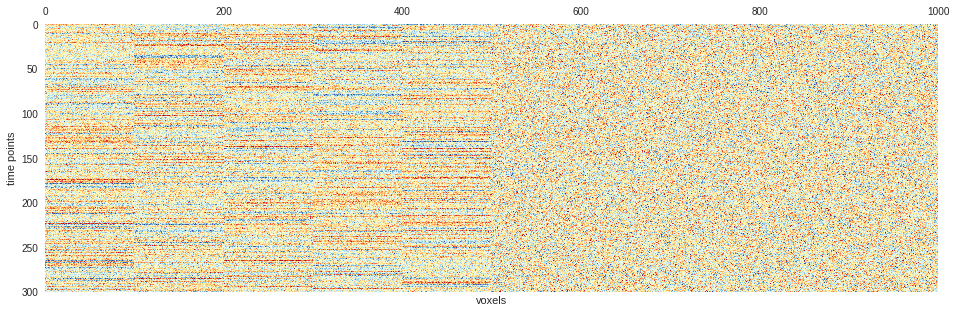

In [30]:
# Create data with where half of voxels are noisy
noisy_data = np.hstack((np.dstack((
    simulated_timeseries(n_subjects, n_TRs,
                         n_voxels=n_voxels // 2, noise=1))),
                        np.dstack((
    simulated_timeseries(n_subjects, n_TRs,
                         n_voxels=n_voxels // 2, noise=9)))))

# Visualize data for first subject where half of voxels are noisy
plt.matshow(noisy_data[..., 0], cmap='RdYlBu_r', vmin=-3, vmax=3)
plt.grid(False)
plt.xlabel('voxels')
plt.ylabel('time points');

After visualizing these data, we'll compute ISCs and use a one-sample two-sided bootstrap hypothesis test, which yields p-values and a null distribution. For this example, we'll use a more realistic number of bootstrap samples (1,000)—this may take a couple minutes.

In [31]:
# Compute ISCs and then run bootstrap hypothesis test on ISCs
# using a realistic number of permutations (takes a few minutes)
iscs = isc(noisy_data, pairwise=True, summary_statistic=None)
observed, ci, p, distribution = bootstrap_isc(iscs, pairwise=True,
                                              ci_percentile=95,
                                              summary_statistic=np.median,
                                              n_bootstraps=1000,
                                              return_distribution=True)

Assuming 20 subjects with 300 time points and 1000 voxel(s) or ROI(s).
Assuming 20 subjects with and 1000 voxel(s) or ROI(s).


### Controlling FDR
To control FDR, we'll use the the `multipletests` function from the StatsModels Python package. This returns an array of q-values, which are typically interpreted as FDR-corrected p-values. By thresholding uncorrected and corrected p- and q-values, we can determine how many voxels survived correction for multiple tests.

In [32]:
# Get q-values (i.e., FDR-controlled p-values) using statsmodels
q = multipletests(p[0, :], method='fdr_by')[1]

# We can also convert these q-values to z-values
z = np.abs(norm.ppf(q))

# Also get significant voxels with and without correction
corrected = q[np.newaxis, :] < .05
uncorrected = p < .05

# Count significant voxels before and after correction
print(f'{np.sum(uncorrected)} "significant" voxels before correction for '
      f"multiple tests; {np.sum(corrected)} significant voxels after "
      f"controlling FDR at .05")

592 "significant" voxels before correction for multiple tests; 504 significant voxels after controlling FDR at .05


Finally, we can visualize the voxel time series for an example subject, the ISC values across subjects, and which voxels are considered significant before and after controlling FDR at .05. Note that before correction even some of the noisy voxels are considered to have significant ISC; however, after correction, the number of significant noisy voxels is reduced.

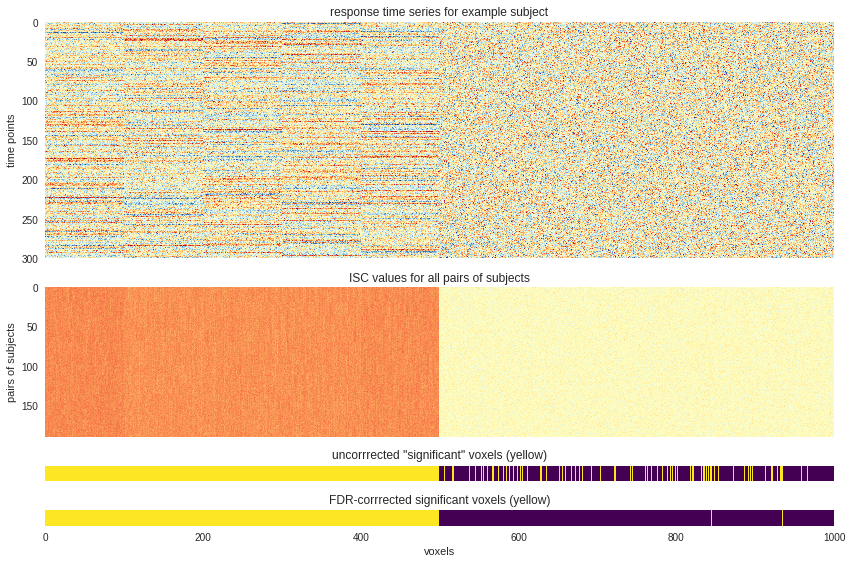

In [33]:
# Set up grid of subplots for visualizing voxel values and significance
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4, figsize=(12, 8),
                                         sharex=True,
                                         gridspec_kw={'height_ratios':
                                                      [300, 190, 20, 20]})

# Visualize data for first subject where half of voxels are noisy
ax0.matshow(noisy_data[..., 0], cmap='RdYlBu_r', vmin=-3, vmax=3)
ax0.grid(False)
ax0.set_ylabel('time points')
ax0.set_title('response time series for example subject', y=1)

# Visualize ISC values across all pairs of subjects
ax1.matshow(iscs, cmap='RdYlBu_r', vmin=-1, vmax=1)
ax1.grid(False)
ax1.set_ylabel('pairs of subjects')
ax1.set_title('ISC values for all pairs of subjects', y=1)

# Visualize uncorrected and corrected significant voxels
ax2.matshow(np.repeat(uncorrected, 20, axis=0),
            cmap='viridis',vmin=0, vmax=1)
ax2.grid(False)
ax2.set_yticks([])
ax2.set_title('uncorrrected "significant" voxels (yellow)')

ax3.matshow(np.repeat(corrected, 20, axis=0),
            cmap='viridis',vmin=0, vmax=1)
ax3.grid(False)
ax3.set_xlabel('voxels')
ax3.xaxis.tick_bottom()
ax3.set_yticks([])
ax3.set_title('FDR-corrrected significant voxels (yellow)')
plt.tight_layout()

### Controlling FWER
To strictly control the FWER, one method is to construct a null distribution of maximum ISC statistics across all voxels. First we'll use the `permutation_isc` function to run a one-sample two-sided permutation test using a sign-flipping procedure, which returns p-values and a null distribution.

In [34]:
# Compute ISCs and then run two-sample permutation test on ISCs
iscs = isc(noisy_data, pairwise=True, summary_statistic=None)
observed, p, distribution = permutation_isc(iscs, pairwise=True,
                                            summary_statistic=np.median,
                                            n_permutations=1000,
                                            return_distribution=True)

Assuming 20 subjects with 300 time points and 1000 voxel(s) or ROI(s).
No group assignment provided, performing one-sample test.
Assuming 20 subjects, 1 group(s), and 1000 voxel(s) or ROI(s).
One-sample approximate permutation test using sign-flipping procedure with Monte Carlo resampling.


Next, we'll write a simple function that takes a null distribution with multiple voxels, and aggregates the maximum ISC value across all voxels for each null sample.

In [0]:
# Loop through null distribution and get maximum value across voxels
def get_maximums(distribution):
  max_distribution = []
  for i in distribution:
    max_isc = np.amax(i)
    max_distribution.append(max_isc)
  max_distribution = np.array(max_distribution)
  return max_distribution

After we create a null distribution of maximum statistics, any voxel with an ISC value in the top 5% of distribution can considered significant. Here we compute p-values from the null distribution of maximum statistics using a two-sided test.

In [0]:
# Create null distribution of maximum ISCs across all voxels
max_distribution = get_maximums(distribution)

# Broadcast our max distribution across all 1000 voxels
max_distribution = np.repeat(max_distribution[:, np.newaxis], 1000, axis=1)

# Get the summary statistic (median) for our actual ISC values
# since we set summary_statistic=None above
observed = np.median(iscs, axis=0)[np.newaxis, :]

# Evaluate whether observed ISCs land in the tail of the max distribution
p_max = ((np.sum(np.abs(max_distribution) >= np.abs(observed), axis=0) + 1) /
          float((len(max_distribution) + 1)))[np.newaxis, :]

# Get p-values less than .05 (corrected for multiple tests)
corrected = p_max < .05

As with the FDR approach,  we can visualize the data and the voxels marked as significant before and after correction for multiple tests. This method of correction for multiple tests is considerably more conservative.

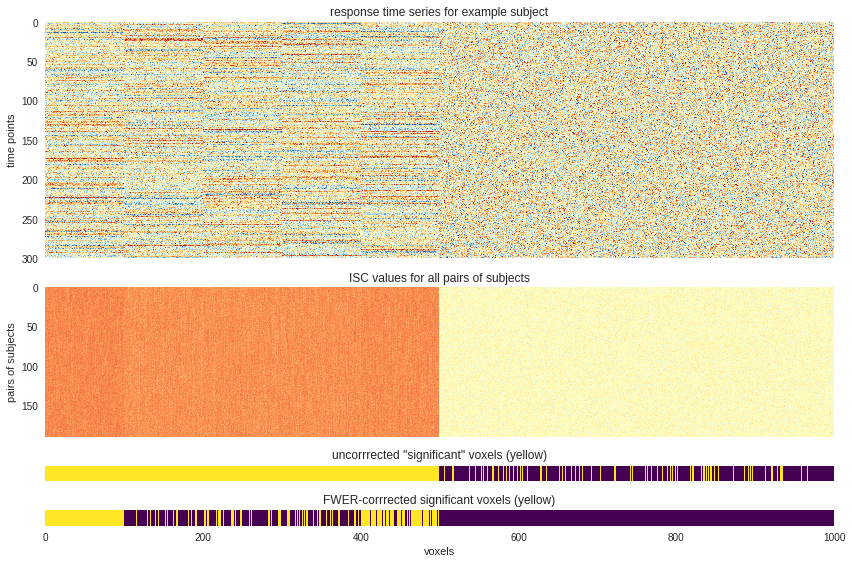

In [38]:
# Set up grid of subplots for visualizing voxel values and significance
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4, figsize=(12, 8),
                                         sharex=True,
                                         gridspec_kw={'height_ratios':
                                                      [300, 190, 20, 20]})

# Visualize data for first subject where half of voxels are noisy
ax0.matshow(noisy_data[..., 0], cmap='RdYlBu_r', vmin=-3, vmax=3)
ax0.grid(False)
ax0.set_ylabel('time points')
ax0.set_title('response time series for example subject', y=1)

# Visualize ISC values across all pairs of subjects
ax1.matshow(iscs, cmap='RdYlBu_r', vmin=-1, vmax=1)
ax1.grid(False)
ax1.set_ylabel('pairs of subjects')
ax1.set_title('ISC values for all pairs of subjects', y=1)

# Visualize uncorrected and corrected significant voxels
ax2.matshow(np.repeat(uncorrected, 20, axis=0),
            cmap='viridis',vmin=0, vmax=1)
ax2.grid(False)
ax2.set_yticks([])
ax2.set_title('uncorrrected "significant" voxels (yellow)')

ax3.matshow(np.repeat(corrected, 20, axis=0),
            cmap='viridis',vmin=0, vmax=1)
ax3.grid(False)
ax3.set_xlabel('voxels')
ax3.xaxis.tick_bottom()
ax3.set_yticks([])
ax3.set_title('FWER-corrrected significant voxels (yellow)')
plt.tight_layout()

Note that there are many other ways to correct for multiple tests, such as using cluster-extent thresholding; but these methods are beyond the scope of this tutorial.

## ISFC analysis
Rather than computing ISCs for corresponding voxels across participants, we can instead compute ISCs between all voxels to measure functional integration (i.e., connectivity). This method is called intersubject functional correlation (ISFC) analysis (Simony et al., 2016). Computing ISFC between a pair of subjects will yield a `n_voxels` by `n_voxels` correlation matrix. The `isfc` function takes many similar arguments to the `isc` function; for example, we can compute ISFCs using either the pairwise or leave-on-out approach.

In the pairwise approach, the `isfc` returns a 3-dimensional numpy array of shape `n_voxels` by `n_voxels` by `n_pairs` where
```
n_pairs = n_subjects * (n_subjects - 1) / 2
```

In [96]:
# Compute ISFCs using pairwise approach
isfcs = isfc(data, pairwise=True)

# Check shape of output ISC values
print(f"ISFC output shape = {isfcs.shape} \ni.e., {isfcs.shape[0]} "
      f"voxels by {isfcs.shape[1]} voxels by {isfcs.shape[2]} pairs")

Assuming 20 subjects with 300 time points and 1000 voxel(s) or ROI(s).
ISC values shape = (1000, 1000, 190) 
i.e., 1000 voxels by 1000 voxels by 190 pairs


Alternatively, we can compute ISFCs using the leave-one-out approach using `pairwise=False`:

In [97]:
# Compute ISFCs using leave-one-out approach
isfcs = isfc(data, pairwise=False)

# Check shape of output ISC values
print(f"ISC output shape = {isfcs.shape} \ni.e., {isfcs.shape[0]} "
      f"voxels by {isfcs.shape[1]} voxels by {isfcs.shape[2]} "
      "left-out subjects")

Assuming 20 subjects with 300 time points and 1000 voxel(s) or ROI(s).
ISC output shape = (1000, 1000, 20) 
i.e., 1000 voxels by 1000 voxels by 20 left-out subjects


We can also supply a `summary_statistic` to collapse the ISFC values over pairs or subjects, resulting in a 2-dimensional `n_voxels` by `n_voxels` array:

In [100]:
# Compute ISFCs using leave-one-out approach with mean
isfcs = isfc(data, pairwise=False, summary_statistic=np.mean)

# Check shape of output ISC values
print(f"ISC output shape = {isfcs.shape} \ni.e., {isfcs.shape[0]} "
      f"voxels by {isfcs.shape[1]} voxels")

Assuming 20 subjects with 300 time points and 1000 voxel(s) or ROI(s).
ISC output shape = (1000, 1000) 
i.e., 1000 voxels by 1000 voxels


Finally, we can visualize the matrix of mean (or median) ISC values. The diagonal blocks represent the 10 artificial "networks" in our simulated data; the 100 voxels in each network are highly correlated with each other and largely uncorrelated with voxels in other networks.

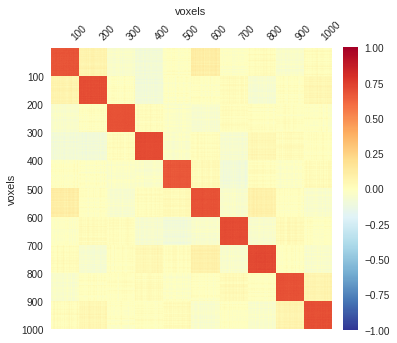

In [102]:
# Visual mean ISFC matrix
plt.matshow(isfcs, cmap="RdYlBu_r", vmin=-1, vmax=1)
plt.grid(False)
plt.xticks(np.arange(0, 1001, 100)[1:], np.arange(100, 1001, 100),
           rotation=45)
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
plt.yticks(np.arange(0, 1001, 100)[1:], np.arange(100, 1001, 100))
plt.xlabel('voxels')
plt.ylabel('voxels')
ax = plt.gca()
plt.colorbar(fraction=0.046, pad=0.04);

The diagonal of the ISFC matrix represents each voxel correlated with itself across subjects—the conventional ISC described above. We can see that the conventional ISC analysis is in fact a subset of the ISFC analysis.

In [112]:
# Get diagonal values from ISFC matrix
isfcs_diagonal = np.diagonal(isfcs)

# Recompute conventional ISCs in the same way
iscs = isc(data, pairwise=False, summary_statistic=np.mean)

# Check that ISFCs diagonal matches ISCs
assert np.allclose(isfcs_diagonal, iscs[0, :])

Assuming 20 subjects with 300 time points and 1000 voxel(s) or ROI(s).


We can inject some structure into our simulated data to yield a more realistic ISFC matrix.

In [0]:
# Create more structured simulated data with 7 "networks";
# don't worry about the details
from scipy.ndimage import gaussian_filter1d

def structured_timeseries(n_subjects, n_TRs, n_voxels=1000, noise=1):
  signals = np.random.randn(n_TRs, 3)
  networks = np.column_stack((signals + np.random.randn(n_TRs, 3) * noise,
                              signals[:, 0] + np.random.randn(n_TRs) * noise,
                              signals[:, 0] + np.random.randn(n_TRs) * noise,
                              -signals[:, 2] + np.random.randn(n_TRs) * noise,
                              signals[:, 2] + np.random.randn(n_TRs) * noise))
  networks = networks[:, [0, 3, 4, 5, 1, 2, 6]]
  six = np.random.randint(n_voxels // 20, n_voxels // 6, 6)
  seven = np.append(six, (n_voxels - np.sum(six)))
  voxels = np.column_stack([np.tile(network[:, np.newaxis], (1, extent))
                            for network, extent in zip(networks.T, seven)])
  areas = [0] + sorted(np.random.randint(0, 1000, 16))
  areas = np.diff(areas).tolist() + [(1000 - areas[-1])]
  noise_sources = np.random.randn(n_TRs, 7)
  structured_noise = np.column_stack([np.tile(
      (noise_sources[:, np.random.choice(range(7))] *
       np.random.choice([-1, 1, 1, 1]))[:, np.newaxis],
                                              (1, extent)) 
                                      for extent in areas])
  voxels = gaussian_filter1d(voxels, 8.0, axis=0)
  structured_noise = gaussian_filter1d(structured_noise, 8.0, axis=0)
  data = []
  for s in np.arange(n_subjects):
    data.append(voxels + structured_noise * noise * .2 +
                np.random.randn(n_TRs, n_voxels) * noise * 1.35)

  data = np.dstack(data)
  return data

structured_data = structured_timeseries(n_subjects, n_TRs)

Now, we can recompute mean ISFCs using the leave-one-out approach and visualize the resulting ISFC matrix.

In [249]:
# Compute ISFCs using leave-one-out approach with mean
isfcs = isfc(structured_data, pairwise=False, summary_statistic=np.mean)

Assuming 20 subjects with 300 time points and 1000 voxel(s) or ROI(s).


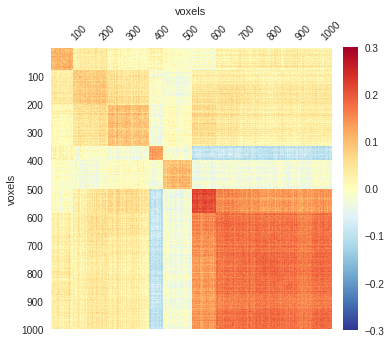

In [250]:
# Visual mean ISFC matrix
plt.matshow(isfcs, cmap="RdYlBu_r", vmin=-.3, vmax=.3)
plt.grid(False)
plt.xticks(np.arange(0, 1001, 100)[1:], np.arange(100, 1001, 100),
           rotation=45)
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
plt.yticks(np.arange(0, 1001, 100)[1:], np.arange(100, 1001, 100))
plt.xlabel('voxels')
plt.ylabel('voxels')
ax = plt.gca()
plt.colorbar(fraction=0.046, pad=0.04);

## References and suggested reading

* Chen, G., Shin, Y. W., Taylor, P. A., Glen, D. R., Reynolds, R. C., Israel, R. B., & Cox, R. W. (2016). Untangling the relatedness among correlations, part I: nonparametric approaches to inter-subject correlation analysis at the group level. *NeuroImage*, *142*, 248–259. https://doi.org/10.1016/j.neuroimage.2016.05.023

* Chen, G., Taylor, P. A., Shin, Y. W., Reynolds, R. C., & Cox, R. W. (2017). Untangling the relatedness among correlations, part II: inter-subject correlation group analysis through linear mixed-effects modeling. *NeuroImage*, *147*, 825–840. https://doi.org/10.1016/j.neuroimage.2016.08.029

* Hasson, U., Malach, R., & Heeger, D. J. (2010). Reliability of cortical activity during natural stimulation. *Trends in Cognitive Sciences*, *14*(1), 40–48. https://doi.org/10.1016/j.tics.2009.10.011

* Hasson, U., Nir, Y., Levy, I., Fuhrmann, G., & Malach, R. (2004). Intersubject synchronization of cortical activity during natural vision. *Science*, *303*(5664), 1634–1640. https://doi.org/10.1126/science.1089506

* Kauppi, J. P., Pajula, J., & Tohka, J. (2014). A versatile software package for inter-subject correlation based analyses of fMRI. *Frontiers in Neuroinformatics*, *8*, 2. https://doi.org/10.3389/fninf.2014.00002

* Lerner, Y., Honey, C. J., Silbert, L. J., & Hasson, U. (2011). Topographic mapping of a hierarchy of temporal receptive windows using a narrated story. *Journal of Neuroscience, 31*(8), 2906–2915. https://doi.org/10.1523/jneurosci.3684-10.2011

* Simony, E., Honey, C. J., Chen, J., Lositsky, O., Yeshurun, Y., Wiesel, A., & Hasson, U. (2016). Dynamic reconfiguration of the default mode network during narrative comprehension. *Nature Communications*, *7*, 12141. https://doi.org/10.1038/ncomms12141